### Initializations for python environment

In [107]:
# first time to create venv and install packages

# %conda create -n corrid-dev anaconda -y
# %conda activate corrid-dev -y

# %conda install -n corrid-dev pandas -y
# %conda install -n corrid-dev xgboost -y

# %conda install pip

### Preprocess logs: Read, Encode categorical attributes by One Hot Encoder, and Store

In [108]:
# encode logs (string features with OneHotEncoder)
import pandas as pd

logs_folder = "./logs/"
bpic17_logs_with_interventions_path = (
    "data_bpic17_readyToUse_preprocessed_for_adaptation_classification.csv"
)
bpic17_logs_with_interventions_path_encoded = (
    "data_bpic17_readyToUse_preprocessed_for_adaptation_classification_encoded.csv"
)


def encode(dataframe):
    from sklearn import preprocessing

    enc = preprocessing.OneHotEncoder(handle_unknown="ignore", sparse=False, dtype=int)
    return enc.fit_transform(dataframe), enc


def store_logs(dataframe, path):
    dataframe.to_csv(logs_folder + path, columns=dataframe.columns, index=False)


def load_logs(path):
    return pd.read_csv(logs_folder + path, quotechar="'")


print(f"encode: {bpic17_logs_with_interventions_path}")
data_df = load_logs(bpic17_logs_with_interventions_path)

column_names_to_encode = [
    "ApplicationType",
    "LoanGoal",
]
columns_to_encode = data_df.loc[:, column_names_to_encode]
encoded_columns, encoder = encode(columns_to_encode)
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out())

data_df_without_encoded_columns = data_df.drop(column_names_to_encode, axis="columns")
data_encoded_df = encoded_df.join(data_df_without_encoded_columns)
# data_encoded_df = data_encoded_df.reset_index()
# print(data_encoded_df.head(5))

store_logs(data_encoded_df, bpic17_logs_with_interventions_path_encoded)


encode: data_bpic17_readyToUse_preprocessed_for_adaptation_classification.csv


### Load logs & prepare for classifications

In [109]:
import numpy
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

def log_pre_process(csv_file_path, memory_reduction, columns_to_drop=[], l2normalize=False):
    print(f"log_pre_process: {csv_file_path}")
    data_df = load_logs(csv_file_path)

    print("Columns before removal:")
    list_of_column_names = list(data_df.columns)
    print(list_of_column_names)

    data_df = data_df.drop(columns=columns_to_drop)

    print("Columns after removal:")
    list_of_column_names = list(data_df.columns)
    print(list_of_column_names)

    # separating class labels from the features (classes, values)
    slice_start_col = 0
    slice_end_col = len(data_df.columns) - 1

    values = data_df.iloc[:, slice_start_col:slice_end_col]
    classes = data_df.iloc[:, slice_end_col:]
    
    # Encoding labels of classes
    le = LabelEncoder()
    classes = le.fit_transform(classes)

    # l2 normalization (optional and based on l2normalize variable)
    if l2normalize:
        print(f"l2 normalization on {csv_file_path}")
        values = preprocessing.normalize(values, norm='l2')

    print()
    data = (values, classes)

    return data, list_of_column_names[:-1], data_df


l2normalize = False

bpic17_logs_columns_to_drop = []

(
    bpic17_logs_with_interventions,
    bpic17_logs_with_interventions_column_names,
    bpic17_logs_with_interventions_df,
) = log_pre_process(
    bpic17_logs_with_interventions_path_encoded,
    memory_reduction=False,
    columns_to_drop=bpic17_logs_columns_to_drop,
    l2normalize=l2normalize
)

synthetic_logs_with_adaptations_path = (
    "sample_sequence_simulation_logs_multi_adapted_noisy_encoded.csv"
)
synthetic_logs_columns_to_drop = [
    "trace_id",
    "event:event_name@A",
    "event:event_name@B",
    "event:event_name@C",
    "event:event_name@D",
    "event:event_name@E",
    "event:event_name@F",
    "event:event_name@I",
    "event:event_name@process end event",
    "event:event_name@process start event",
    "event:concept:name@A",
    "event:concept:name@B",
    "event:concept:name@C",
    "event:concept:name@D",
    "event:concept:name@E",
    "event:concept:name@F",
    "event:concept:name@I",
    "event:concept:name@process end event",
    "event:concept:name@process start event",
    "event:adaptation_action@insert",
    "event:adaptation_action@no-action",
    "event:adaptation_action@skip",
    "event:@@index",
    "event:@@case_index",
    "event:trace_id",
    "succession:concept:name@A#B",
    "succession:concept:name@B#C",
    "succession:concept:name@C#D",
    "succession:concept:name@D#E",
    "succession:concept:name@D#F",
    "succession:concept:name@E#F",
    "succession:concept:name@F#process end event",
    "succession:concept:name@process end event#I",
    "succession:concept:name@process start event#A",
    "event:resource",
    "event:duration",
]
(
    synthetic_logs_with_adaptations,
    synthetic_logs_with_adaptations_column_names,
    synthetic_logs_with_adaptations_df,
) = log_pre_process(
    synthetic_logs_with_adaptations_path,
    memory_reduction=False,
    columns_to_drop=synthetic_logs_columns_to_drop,
    l2normalize=l2normalize
)


log_pre_process: data_bpic17_readyToUse_preprocessed_for_adaptation_classification_encoded.csv
Columns before removal:
['ApplicationType_Limit raise', 'ApplicationType_New credit', 'LoanGoal_Car', 'LoanGoal_Caravan / Camper', 'LoanGoal_Existing loan takeover', 'LoanGoal_Extra spending limit', 'LoanGoal_Home improvement', 'LoanGoal_Motorcycle', 'LoanGoal_Not speficied', 'LoanGoal_Other see explanation', 'LoanGoal_Remaining debt home', 'LoanGoal_Unknown', 'LoanGoal_other', 'RequestedAmount', 'CreditScore', 'timesincefirstcase', 'duration', 'FirstWithdrawalAmount', 'MonthlyCost', 'NumberOfTerms', 'OfferedAmount', 'open_cases', 'month', 'weekday', 'hour', 'treatment']
Columns after removal:
['ApplicationType_Limit raise', 'ApplicationType_New credit', 'LoanGoal_Car', 'LoanGoal_Caravan / Camper', 'LoanGoal_Existing loan takeover', 'LoanGoal_Extra spending limit', 'LoanGoal_Home improvement', 'LoanGoal_Motorcycle', 'LoanGoal_Not speficied', 'LoanGoal_Other see explanation', 'LoanGoal_Remaini

/Users/arash/opt/anaconda3/envs/corrid-dev/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arash/opt/anaconda3/envs/corrid-dev/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



### Classifier comparison (now just Decision Tree and print the tree model)

l2 normalization = False
Dataset: bpic17_logs_with_interventions-----------------------------


Best hyperparameters: {'n_neighbors': 40, 'weights': 'uniform'}
Classifier: Nearest Neighbors

F1: 0.5514330555307441
Precision: 0.5695691591752319
Recall: 0.5610377208339965


Best hyperparameters: {'ccp_alpha': 0.01, 'criterion': 'entropy', 'min_samples_leaf': 2, 'splitter': 'best'}
Classifier: Decision Tree

F1: 0.7929473455183665
Precision: 0.7960020173392647
Recall: 0.7935699506605125


Best hyperparameters: {'max_features': 'auto', 'n_estimators': 5, 'random_state': 42}
Classifier: Random Forest

F1: 0.6959270358372063
Precision: 0.696333808564783
Recall: 0.6961642527455038


Best hyperparameters: {'var_smoothing': 1e-09}
Classifier: Gaussian Naive Bayes

F1: 0.6704302879371637
Precision: 0.6713040279007405
Recall: 0.6705395511698233


Best hyperparameters: {'alpha': 0.1, 'fit_prior': False}
Classifier: Mutlinomial Naive Bayes

F1: 0.5244887906853366
Precision: 0.5438668358993389
Recal

/Users/arash/opt/anaconda3/envs/corrid-dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best hyperparameters: {'max_features': 'auto', 'n_estimators': 5, 'random_state': 42}
Classifier: Random Forest

F1: 0.9088824969400245
Precision: 0.9032511467889909
Recall: 0.915


Best hyperparameters: {'var_smoothing': 1e-09}
Classifier: Gaussian Naive Bayes

F1: 0.7620659084281131
Precision: 0.7945945945945945
Recall: 0.79


Best hyperparameters: {'alpha': 1.0, 'fit_prior': True}
Classifier: Mutlinomial Naive Bayes

F1: 0.6507557857258456
Precision: 0.6330459770114942
Recall: 0.67




/Users/arash/opt/anaconda3/envs/corrid-dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arash/opt/anaconda3/envs/corrid-dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best hyperparameters: {'colsample_bytree': 1, 'learning_rate': 0.01, 'n_estimators': 10, 'random_state': 42, 'subsample': 1}
Classifier: XGBoost

F1: 0.9375454052588776
Precision: 0.9343018018018018
Recall: 0.945




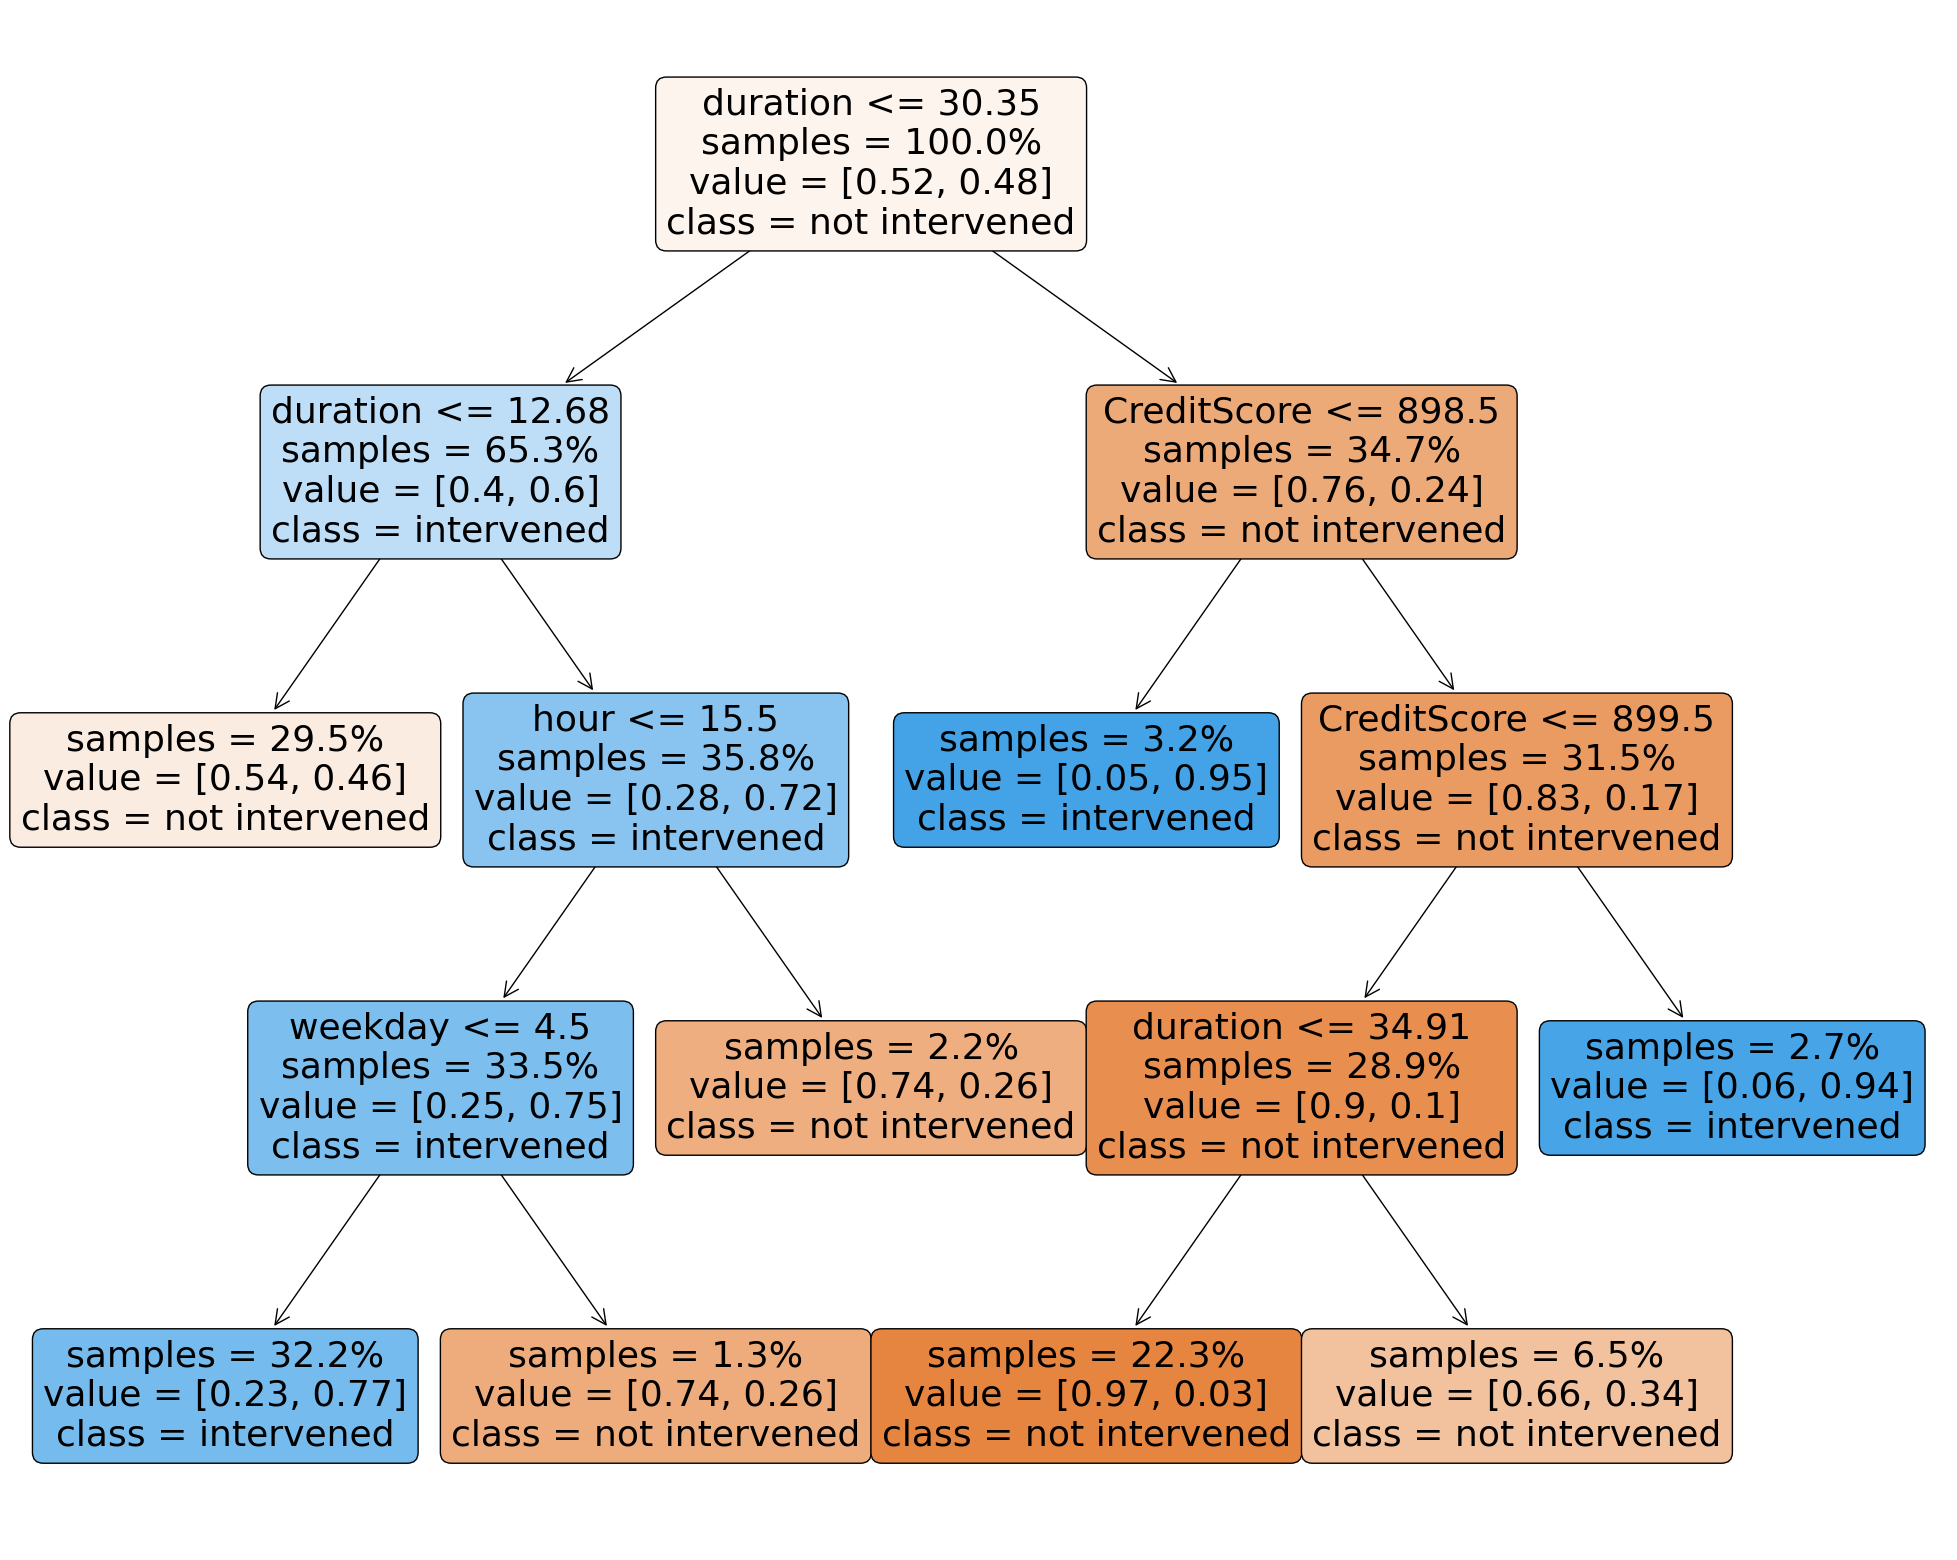

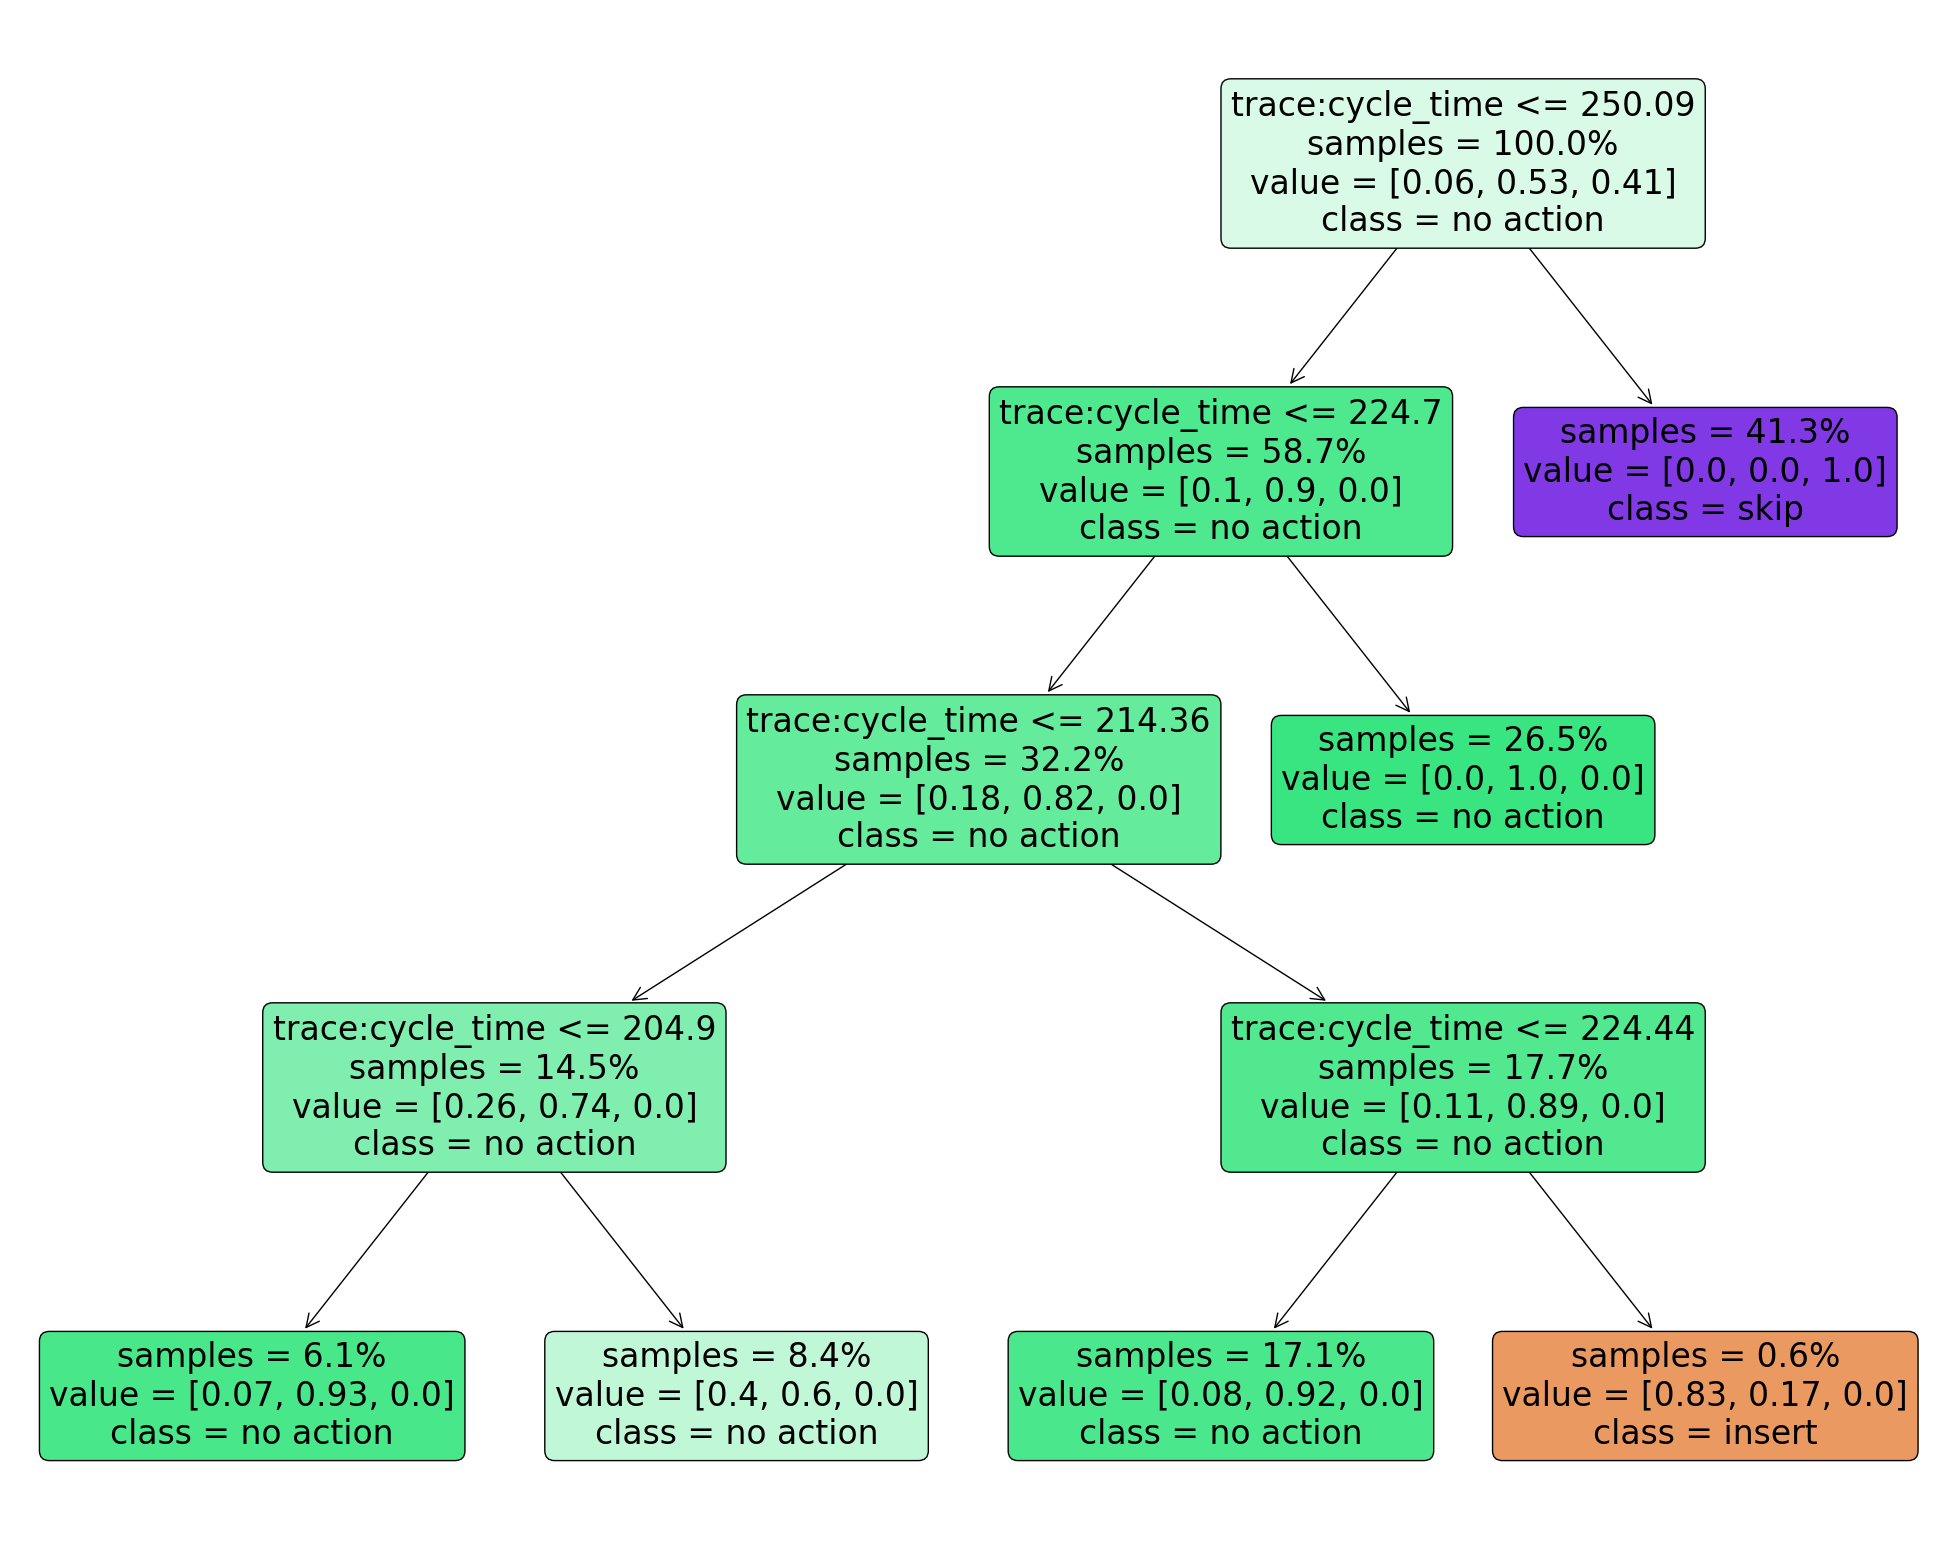

In [110]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn import tree
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_text

from xgboost import XGBClassifier

def find_best_parameters(classifier_name, classifier, train_features, train_labels):
    # hyperparameter tuning (to reduce run time, param grids are limited around the optimum we found. To search in a larger grid commented param_grid could be used instead.)

    if classifier_name == "Nearest Neighbors":
        param_grid = {
            'n_neighbors': [5, 10, 20, 40, 60, 65, 80],  # Number of neighbors to consider
            'weights': ['uniform','distance'],  # Weights used in prediction
        }
        # param_grid = {
        #     'n_neighbors': [5, 10, 20, 40, 60, 65, 80],  # Number of neighbors to consider
        #     'weights': ['uniform', 'distance'],  # Weights used in prediction
        #     'p': [1, 2],  # Power parameter for Minkowski metric (1 for Manhattan distance, 2 for Euclidean distance)
        # }
    elif classifier_name == "Decision Tree":
        param_grid = {
            'criterion': ['gini', 'entropy'],
            'splitter': ['best', 'random'],
            'min_samples_leaf': [2],
            'ccp_alpha': [0.01, 0.03, 0.05, 0.07]
        }
        # param_grid = {
        #     'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10], 
        #     'criterion': ['gini', 'entropy'],
        #     'splitter': ['best', 'random'],
        #     'min_samples_leaf': [3, 5, 10, 50],
        #     'ccp_alpha': [0.005, 0.01, 0.03, 0.05, 0.07],
        # }
    elif classifier_name == "Random Forest":
        param_grid = {
            'n_estimators': [5, 10, 50, 100], # Number of decision trees in the Random Forest
            'max_features': ['auto'], # Number of features to consider for best split
            'random_state': [42] # Seed for random number generator
        }
        # param_grid = {
        #     'n_estimators': [50, 100, 200, 300], # Number of decision trees in the Random Forest
        #     'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10], # Maximum depth of each decision tree
        #     'min_samples_split': [2, 5, 10], # Minimum number of samples required to split a node
        #     'min_samples_leaf': [2, 4, 8, 16, 32, 64], # Minimum number of samples required to be at a leaf node
        #     'max_features': ['auto', 'sqrt', 'log2'], # Number of features to consider for best split
        #     'random_state': [42] # Seed for random number generator
        # }
    elif classifier_name == "Gaussian Naive Bayes":
        param_grid = {
            'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
        }
    elif classifier_name == "Mutlinomial Naive Bayes":
        param_grid = {
            'alpha': [0.1, 0.5, 1.0, 2.0],  # Smoothing parameter
            'fit_prior': [True, False]  # Whether to learn class prior probabilities
        }
    elif classifier_name == "XGBoost":
        param_grid = {
            'n_estimators': [10, 50, 100, 200],  # The number of trees in the forest
            'learning_rate': [0.01, 0.05, 0.1, 0.2],  # controls the step size at each boosting iteration. A smaller learning rate may lead to better generalization performance but require more boosting iterations.
            'subsample': [0.5, 0.8, 1],  # sets the fraction of samples used for each boosting iteration. A value less than 1.0 results in sub-sampling. Smaller values can reduce variance, but may increase bias.
            'colsample_bytree': [0.5, 0.8, 1],  # fraction of columns (features) used for each boosting iteration
            'random_state': [42] # Seed for random number generator
        }
        # param_grid = {
        #     'n_estimators': [50, 100, 200],  # The number of trees in the forest
        #     'learning_rate': [0.01, 0.1, 0.2],  # controls the step size at each boosting iteration. A smaller learning rate may lead to better generalization performance but require more boosting iterations.
        #     'max_depth': [3, 5, 7],  # maximum depth of the decision trees used in the boosting process
        #     'subsample': [0.5, 0.8, 1],  # sets the fraction of samples used for each boosting iteration. A value less than 1.0 results in sub-sampling. Smaller values can reduce variance, but may increase bias.
        #     'colsample_bytree': [0.5, 0.8, 1],  # fraction of columns (features) used for each boosting iteration
        #     'random_state': [42] # Seed for random number generator
        # }
    else:
        return classifier.get_params()

    # hyper-parameter tuning using cross validation with 5 folds (80% train - 20% validation) and choosing the best according to f1 score
    # verbose = 2 for debugging
    grid_search = GridSearchCV(classifier, param_grid, cv=5, n_jobs=-1, verbose=0, scoring="f1_weighted")
    grid_search.fit(train_features, train_labels)

    best_params = grid_search.best_params_
    print("Best hyperparameters:", best_params)
    
    return best_params

# https://mljar.com/blog/visualize-decision-tree/
def visualize_decision_tree(dtree, feature_names, class_names, file_path):
    from sklearn.tree import plot_tree
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize=((25,20)))
    
    _ = plot_tree(dtree,
                feature_names= feature_names,
                class_names= class_names,
                precision=2, 
                filled= True,
                proportion= True,
                impurity= False,
                rounded= True)
    
    fig.savefig(file_path)

outputs_folder = "./outputs/"
decision_tree_output_file_name = "output_decision_trees.txt"
multi_classification_output_file_name = "output_multiple_classification.txt"

classifier_names = [
    "Nearest Neighbors",
    "Decision Tree",
    "Random Forest",
    "Gaussian Naive Bayes",
    "Mutlinomial Naive Bayes",
    "XGBoost"

    # "Linear SVM",
    # "RBF SVM",
    # "Gaussian Process",
    # "Neural Net (Multi-layer Perceptron)",
    # "AdaBoost",
    # "Quadratic Discriminant Analysis",
]


classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GaussianNB(),
    MultinomialNB(),
    XGBClassifier()

    # SVC(kernel="linear"),
    # SVC(gamma=2, C=1),
    # GaussianProcessClassifier(1.0 * RBF(1.0)),
    # MLPClassifier(alpha=1, max_iter=1000),
    # AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=8)),
    # QuadraticDiscriminantAnalysis(),
]

datasets_df = [bpic17_logs_with_interventions_df, synthetic_logs_with_adaptations_df]

datasets = [bpic17_logs_with_interventions, synthetic_logs_with_adaptations]

dataset_names = ["bpic17_logs_with_interventions", "synthetic_logs_with_adaptations"]

dataset_feature_names = [
    bpic17_logs_with_interventions_column_names,
    synthetic_logs_with_adaptations_column_names,
]

dataset_class_names = [
    ["not intervened", "intervened"],
    ["insert", "no action", "skip"]
]

multi_classification_output_file = open(
    file=outputs_folder + multi_classification_output_file_name, mode="w"
)
decision_tree_output_file = open(
    file=outputs_folder + decision_tree_output_file_name, mode="w"
)

print(f"l2 normalization = {l2normalize}")

# iterate over datasets
for dataset_index, dataset in enumerate(datasets):

    features, labels = dataset

    # Data split: 80% train - 20% test
    test_size_value = 0.2
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=test_size_value, shuffle=False)

    dataset_name = dataset_names[dataset_index]
    out_text = f"Dataset: {dataset_name}-----------------------------\n\n"
    print(out_text)
    multi_classification_output_file.write(out_text)
    decision_tree_output_file.write(out_text)

    # iterate over classifiers
    for classifier_name, classifier in zip(classifier_names, classifiers):
        
        # find best parameters - Hyper parameter tuning
        best_params = find_best_parameters(classifier_name, classifier, train_features, train_labels)

        classifier.set_params(**best_params)

        out_text_classifier = f"Classifier: {classifier_name}"
        out_text_parameters = f"\nParameters: {classifier.get_params()}"

        print(out_text_classifier)
        multi_classification_output_file.write(
            out_text_classifier + out_text_parameters
        )

        # Train the classifier on the train set with tuned hyper parameters
        classifier.fit(train_features, train_labels)

        # Predict on the test set
        labels_prediction = classifier.predict(test_features)

        # Calculate precision, recall, and F1 score
        f1 = f1_score(test_labels, labels_prediction, average='weighted')
        precision = precision_score(test_labels, labels_prediction, average='weighted')
        recall = recall_score(test_labels, labels_prediction, average='weighted')

        out_text = (
            f"\nF1: {f1}\n" + 
            f"Precision: {precision}\n" + 
            f"Recall: {recall}\n\n"
        )

        print(out_text)
        multi_classification_output_file.write(out_text)

        # For decision tree, we plot and export a trained model on the whole dataset for visualization purposes
        if classifier_name == "Decision Tree":
            # we use raw features (i.e. not normalized)
            classifier.fit(features, labels)
            feature_names = dataset_feature_names[dataset_index]
            class_names = dataset_class_names[dataset_index]
            
            text_representation = tree.export_text(
                classifier, feature_names=feature_names
            )
            decision_tree_output_file.write(out_text_classifier + out_text_parameters)
            out_text_tree = (
                f"\n\nDecision Tree on the whole data set:\n{text_representation}\n\n"
            )
            decision_tree_output_file.write(out_text_tree)

            visualized_decision_tree_file_path = outputs_folder + 'decision_tree_' + dataset_name + '.png'
            visualize_decision_tree(classifier, feature_names, class_names, visualized_decision_tree_file_path)

multi_classification_output_file.close()
decision_tree_output_file.close()